Part 1 and Part 2.1

In [43]:
from scipy import stats
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
n,loc_true,scale_true,df_true = 100,10,2,15
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n) # Data from location-scale-t distribution

HMC Split-Rhats {'loc': 1.0016, 'scale': 1.0028, 'df': 1.0011} | 

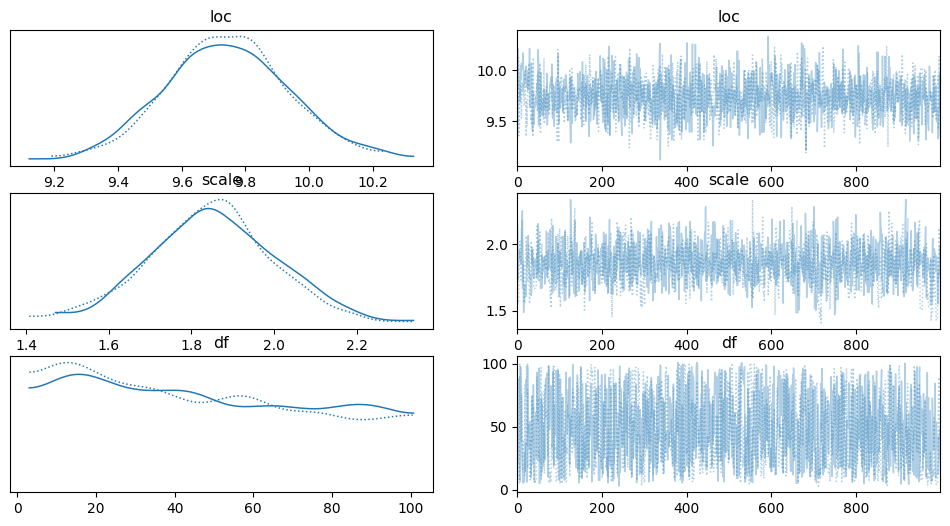

In [44]:
new_model = pm.Model()
with new_model:
    loc = pm.Normal('loc', mu=0, sigma=10)
    scale = pm.HalfNormal('scale', sigma=5)
    df = pm.Uniform('df', lower=1, upper=101)
    x_obs = pm.StudentT('likelihood', mu=loc, sigma=scale, nu=df, observed=x)
with new_model:
    idata_HMC = pm.sample()
with new_model:
    az.plot_trace(idata_HMC)
## R_hat
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | ')

In [45]:
print("Number of MCMC samples:", idata_HMC.posterior["loc"].values.flatten().shape[-1])
# Generate summary which includes effective sample size
summary = az.summary(idata_HMC, round_to=2)
print(summary)
print(summary['ess_bulk'])

Number of MCMC samples: 2000
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
loc     9.74   0.19    9.36    10.08       0.00     0.00   1808.68   1601.57   
scale   1.85   0.15    1.55     2.12       0.00     0.00   1220.66    401.50   
df     47.41  28.16    5.13    94.45       0.91     0.64    823.51   1027.36   

       r_hat  
loc      1.0  
scale    1.0  
df       1.0  
loc      1808.68
scale    1220.66
df        823.51
Name: ess_bulk, dtype: float64


In [46]:
divergence = idata_HMC.sample_stats.acceptance_rate.values.flatten()
print(f"Divergences:{divergence}")

Divergences:[0.80943842 0.21101657 0.91026356 ... 0.73173648 0.9049569  0.41205497]


Part 2.2

In [47]:
import numpy as np
J = 8
y = np.array([28.0, 8.0,-3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])
# Assume the prior distribution, probabilistic hierarchy and likelihood for the centered model
import pymc as pm
with pm.Model() as Centered_eight:
  mu = pm.Normal("mu", mu=0, sigma=5)
  tau = pm.HalfCauchy("tau", beta = 5)
  theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J)
  obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

In [48]:
# Set random distribution
SEED = [20100420, 20134234]
with Centered_eight:
  fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                    return_inferencedata=True, idata_kwargs={"log_likelihood": True})

In [49]:
# Assume the prior distribution, probabilistic hierarchy and likelihood for the centered model
with pm.Model() as NonCentered_eight:
  mu = pm.Normal("mu", mu=0, sigma=5)
  tau = pm.HalfCauchy("tau", beta = 5)
  theta = pm.Normal("theta", mu=0, sigma=1, shape=J)
  obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

In [50]:
# Set random distribution
SEED = [20100420, 20134234]
with NonCentered_eight:
  fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                    return_inferencedata=True, idata_kwargs={"log_likelihood": True})

In [51]:
# Effective Sample Size
import pandas as pd
print("Effective Sample Sizes (function of Markov chain autocorrelation dependency)")
pd.concat(
[pd.DataFrame({'Centered': pm.summary(fit_C)[:1]['ess_bulk'],
                         'Non-Centered': pm.summary(fit_NC)['ess_bulk'][:1]}),
pd.DataFrame({'Centered': pm.summary(fit_C)[1:]['ess_bulk'],
              'Non-centered': pm.summary(fit_NC)['ess_bulk'][9:]})])

Effective Sample Sizes (function of Markov chain autocorrelation dependency)


,Centered,Non-Centered,Non-centered
mu,623.0,12903.0,NaN
tau,129.0,NaN,10414.0
theta[0],538.0,NaN,NaN
theta[1],978.0,NaN,NaN
theta[2],1575.0,NaN,NaN
theta[3],965.0,NaN,NaN
theta[4],1673.0,NaN,NaN
theta[5],1769.0,NaN,NaN
theta[6],415.0,NaN,NaN
theta[7],1248.0,NaN,NaN


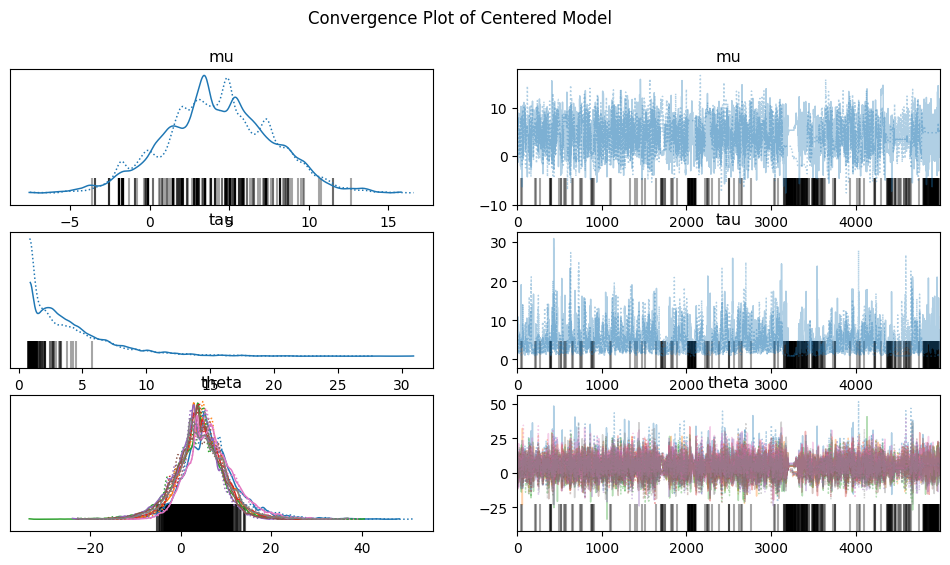

In [52]:
az.plot_trace(fit_C, var_names=['mu', 'tau', 'theta'])
plt.suptitle('Convergence Plot of Centered Model')
plt.show()

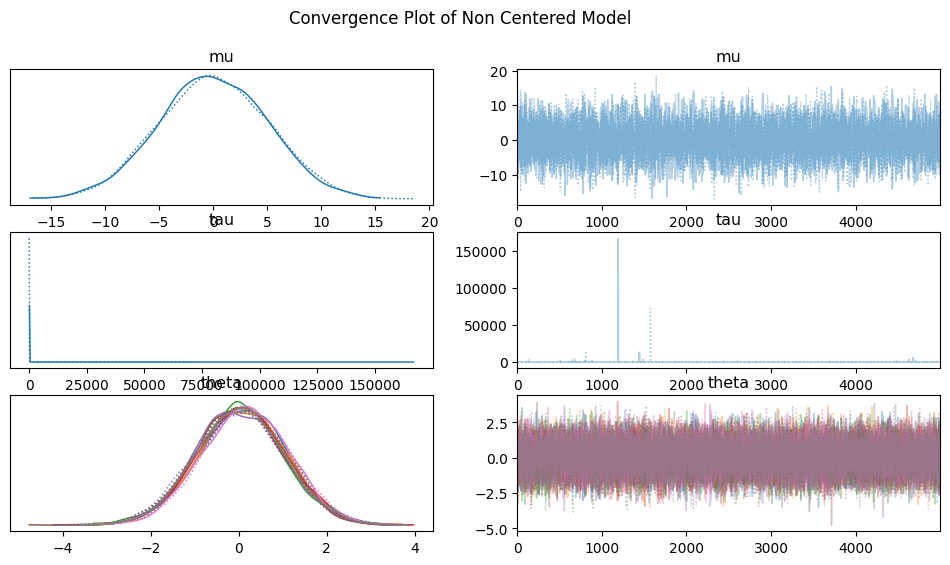

In [53]:
az.plot_trace(fit_NC, var_names=['mu', 'tau', 'theta'])
plt.suptitle('Convergence Plot of Non Centered Model')
plt.show()

In [54]:
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(fit_C).items()}, end=' | ')

HMC Split-Rhats {'mu': 1.0055, 'theta': array([1.0065, 1.0039, 1.0032, 1.0046, 1.0017, 1.0035, 1.006 , 1.0024]), 'tau': 1.0226} | 

In [55]:
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(fit_NC).items()}, end=' | ')

HMC Split-Rhats {'mu': 0.9999, 'theta': array([1.    , 1.0001, 1.0004, 1.    , 1.0004, 1.0005, 1.0001, 1.0004]), 'tau': 1.0002} | 

In [56]:
divergence = fit_C.sample_stats.acceptance_rate.values.flatten()
print(f"Divergences_Center:{divergence}")

Divergences_Center:[7.57529151e-01 9.72231513e-01 9.54940855e-01 ... 5.70538494e-04
 6.60861775e-02 3.10133553e-06]


In [57]:
divergence = fit_NC.sample_stats.acceptance_rate.values.flatten()
print(f"Divergences_Noncenter:{divergence}")

Divergences_Noncenter:[0.97226857 0.87624333 0.58295039 ... 0.7150432  0.38731649 1.        ]


<Axes: >

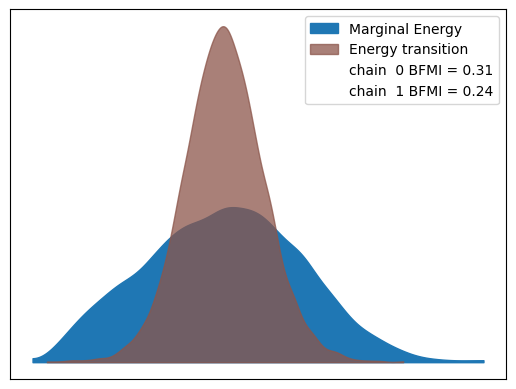

In [60]:
import arviz as az
az.plot_energy(fit_C)

<Axes: >

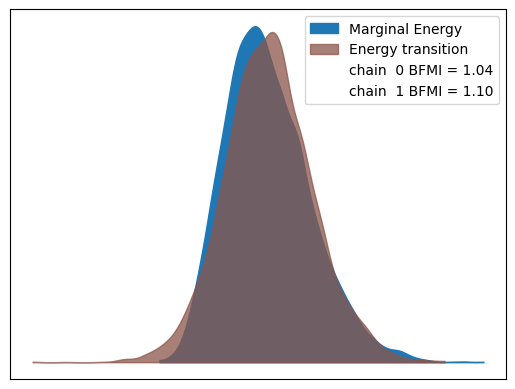

In [61]:
import arviz as az
az.plot_energy(fit_NC)